In [12]:
import pandas as pd
data = pd.read_csv('../data_train/stringtie_tss_labeled.csv')
print("StringTie TSS",data['label'].value_counts())
print("StringTie TSS",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data_true = data[data['label'] == 1].sample(frac=1).head(5)
print("True TSS")
print(data_true[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
data_false = data[data['label'] == 0].sample(frac=1).head(5)
print("False TSS")
print(data_false[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
pdata = data[data['chrom'] == 'chr15']
print(pdata[['chrom', 'position', 'label']].iloc[:26])

data = pd.read_csv('../data_train/stringtie_tes_labeled.csv')
print("StringTie TES",data['label'].value_counts())
print("StringTie TES",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data = pd.read_csv('../data_train/isoquant_tss_labeled.csv')
print("IsoQuant TSS",data['label'].value_counts())
print("IsoQuant TSS",data['label'].value_counts(normalize=True))
data = pd.read_csv('../data_train/isoquant_tes_labeled.csv')
print("IsoQuant TES",data['label'].value_counts())
print("IsoQuant TES",data['label'].value_counts(normalize=True))


# print minimum 5 and maximum 5 delta coverage rows

# print(data.loc[data['delta_coverage'].idxmax(), ['chrom', 'position', 'delta_coverage']])
# print(data.loc[data['delta_coverage'].idxmin(), ['chrom', 'position', 'delta_coverage']])

# # print five chromosomes and positions with label 1
# print(data.loc[data['label'] == 1, ['chrom', 'position', 'delta_coverage']].sample(frac=1).head(5))
# print(data.columns)

StringTie TSS label
0    6851
1    5639
Name: count, dtype: int64
StringTie TSS label
0    0.548519
1    0.451481
Name: proportion, dtype: float64
chrom
chr1          1248
chr2           853
chr19          829
chr17          779
chr3           711
chr12          701
chr11          693
chr6           632
chr7           626
chr5           585
chr16          582
chr9           510
chr14          446
chr4           446
chr10          445
chr15          412
chr8           408
chrX           373
chr22          338
chr20          306
chr13          247
chr18          164
chr21          131
chrY            10
GL000195.1       4
GL000205.2       4
KI270742.1       2
GL000218.1       1
KI270721.1       1
GL000219.1       1
GL000224.1       1
GL000194.1       1
Name: count, dtype: int64
True TSS
      chrom  position  delta_coverage  read_start_density
6226  chr19  38619186           20947                 333
3160  chr13  32586455             197                   3
292    chr1  32650591         

In [8]:
import os
import pandas as pd
from glob import glob

# Paths
REPORTS_DIR = "../out/reports"
OUTPUT_MD = os.path.join(REPORTS_DIR, "metrics_summary.md")

# Model variants we expect in filenames
MODELS = ["xgboost", "randomforest"]
SITE_TYPES = ["tss", "tes"]
TOOLS = ["stringtie", "isoquant"]

results = []

# Search for all metrics summary files
for site_type in SITE_TYPES:
    for tool in TOOLS:
        for model in MODELS:
            path = os.path.join(REPORTS_DIR, site_type, f"{tool}_{model}_metrics_summary.txt")
            if not os.path.exists(path):
                print(f"⚠️ No metrics file found for {tool} {model} on {site_type}. Skipping.")
                continue

            metrics = {
                "Tool": tool,
                "Site Type": site_type,
                "Model": model
            }
            with open(path) as f:
                lines = f.readlines()

                # Track confusion matrix separately
                confusion = {}

                for i, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue
                    if line.startswith("confusion_matrix"):
                        for j in range(1, 5):
                            if i + j < len(lines):
                                subline = lines[i + j].strip()
                                if ":" in subline:
                                    subkey, subval = subline.split(":", 1)
                                    confusion[subkey.strip()] = int(subval.strip())
                        continue
                    if ":" in line:
                        key, value = line.split(":", 1)
                        key = key.strip().lower()
                        try:
                            metrics[key] = float(value.strip())
                        except ValueError:
                            continue
                
                metrics.update({
                    "TP": confusion.get("TP", 0),
                    "FP": confusion.get("FP", 0),
                    "FN": confusion.get("FN", 0),
                    "TN": confusion.get("TN", 0)
                })
                # Class 1 (positive)
                tp = metrics["TP"]
                fp = metrics["FP"]
                fn = metrics["FN"]
                tn = metrics["TN"]

                prec_1 = tp / max(tp + fp, 1)
                rec_1  = tp / max(tp + fn, 1)
                f1_1   = 2 * prec_1 * rec_1 / max(prec_1 + rec_1, 1)

                # Class 0 (negative)
                prec_0 = tn / max(tn + fn, 1)
                rec_0  = tn / max(tn + fp, 1)
                f1_0   = 2 * prec_0 * rec_0 / max(prec_0 + rec_0, 1)

                metrics.update({
                    "precision_class_1": prec_1,
                    "recall_class_1": rec_1,
                    "f1_class_1": f1_1,
                    "precision_class_0": prec_0,
                    "recall_class_0": rec_0,
                    "f1_class_0": f1_0,
                })

                # Add class-wise results
                
            results.append(metrics)

# Create markdown report
if results:
    df = pd.DataFrame(results)
    df = df[[
        "Tool", "Site Type", "Model",
        "accuracy", "precision", "recall", "f1", "aupr", "auc",
        "TP", "FP", "FN", "TN",
        "precision_class_1", "recall_class_1", "f1_class_1",
        "precision_class_0", "recall_class_0", "f1_class_0"
    ]]

    os.makedirs(REPORTS_DIR, exist_ok=True)
    with open(OUTPUT_MD, "w") as f:
        f.write("# Combined Model Evaluation Summary\n\n")
        f.write(df.to_markdown(index=False))
    print(f"✅ Markdown summary written to {OUTPUT_MD}")
else:
    print("⚠️ No metrics files found. Nothing to summarize.")


✅ Markdown summary written to ../out/reports/metrics_summary.md


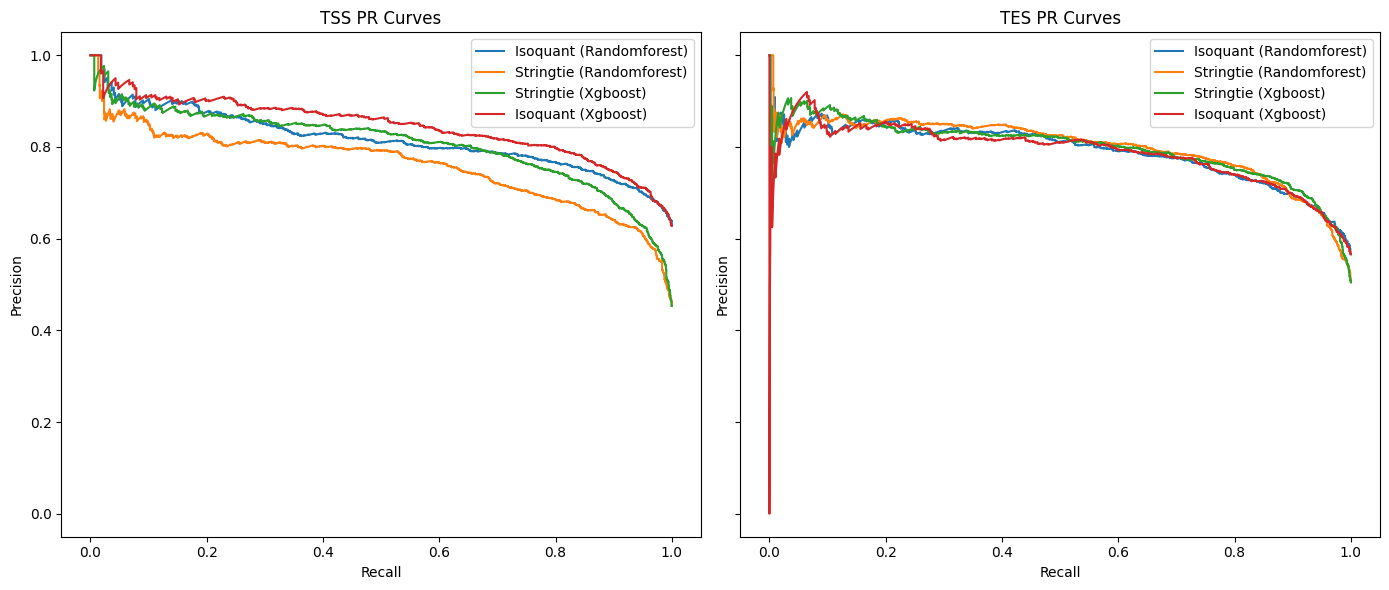

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Get PR curve data CSVs
tss_files = glob.glob("../out/plots/tss/*_pr_data.csv")
tes_files = glob.glob("../out/plots/tes/*_pr_data.csv")

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot TSS
for file in tss_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[0].plot(df["recall"], df["precision"], label=f"{label})")
axs[0].set_title("TSS PR Curves")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].legend()

# Plot TES
for file in tes_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[1].plot(df["recall"], df["precision"], label=f"{label})")
axs[1].set_title("TES PR Curves")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

# Save and show
plt.tight_layout()
plt.savefig("../out/plots/pr_curves_tss_tes_subplots.png")
plt.show()


In [15]:
x = tss_files[0]
t = x.split("/")[-1].replace("_pr_curve_pr_data.csv", "").split("_")
print((t[0]  + " (" + t[1] + ")").title())

Isoquant (Randomforest)
